# Video pipeline with Yolo + Resnet Model

In [398]:
import pandas as pd
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative

In [399]:
series = 84

series_path = os.path.join(FINAL_RESULTS_PATH, "series", str(series))

loader = AdaptationParser(
    series_path=series_path, model_name="video", type_of="pipeline"
)

In [400]:
configs = loader.load_configs()
for config_name, config in configs.items():
    print(f"File name: {config_name}")
    pp.pprint(config)
accuracy_method = config["accuracy_method"]
adaptation_interval = config["adaptation_interval"]
simulation_mode = config["simulation_mode"]

File name: 2.yaml
{   'accuracy_method': 'sum',
    'adaptation_interval': 20,
    'allocation_mode': 'base',
    'alpha': 0,
    'baseline_mode': 'scale',
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'gamma': 0,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'metadata': 'repeant of 66 on UC servers',
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 10,
    'nodes': [   {   'cpu_request': '2',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
                     'memory_request': '2Gi',
                     'model_variants': 'yolov5n',
                     'node_name': 'yolo',
                     'num_interop_threads': '1',
                     

In [401]:
# load the sent workload
workload_type = config["workload_type"]
workload_config = config["workload_config"][0]
start = workload_config["start"]
end = workload_config["end"]
damping_factor = workload_config["damping_factor"]
sent_load = twitter_workload_generator(
    days=f"{start}-{end}", damping_factor=damping_factor
)

In [402]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
if not simulation_mode:
    results = loader.result_processing()

In [403]:
adaptation_log = loader.load_adaptation_log()

In [404]:
series_changes = loader.series_changes(
    adaptation_log=adaptation_log
)  # TODO go inside this

## Comparing Predicted Load with the Recieved Load

[5, 6, 6, 7, 5, 5, 5, 5, 8, 7, 8, 6, 5, 6, 5, 5, 8, 5, 6, 6, 5, 4, 5, 5, 6, 5, 4, 7, 5, 7, 5, 6, 5, 7, 6, 6, 4, 6, 6, 4, 6, 6, 4, 5, 5, 5, 5, 6, 5, 6, 4, 6, 5, 7, 5, 5, 4, 5, 5, 5, 6, 4, 6, 4, 5, 5, 5, 8, 7, 4, 4, 6, 5, 4, 6, 6, 6, 5, 5, 6, 4, 4, 8, 6, 4, 7, 6, 6, 7, 5, 6, 6, 6, 7, 6, 5, 3, 5, 5, 5, 4, 7, 8, 5, 5, 5, 5, 5, 4, 5, 5, 6, 5, 5, 6, 4, 4, 5, 5, 7, 6, 7, 5, 5, 4, 5, 5, 6, 7, 7, 5, 7, 6, 7, 7, 8, 6, 5, 3, 5, 5, 6, 6, 5, 5, 5, 7, 6, 5, 6, 6, 6, 6, 4, 5, 4, 4, 6, 5, 6, 6, 5, 6, 6, 6, 4, 4, 4, 4, 6, 5, 3, 4, 5, 5, 4, 5, 6, 6, 4, 5, 6, 4, 5, 4, 4, 4, 5, 3, 3, 5, 5, 4, 5, 6, 4, 7, 5, 5, 5, 6, 5, 6, 5, 4, 4, 6, 4, 5, 5, 5, 6, 4, 6, 6, 7, 5, 5, 3, 5, 4, 5, 7, 6, 6, 7, 4, 5, 5, 5, 6, 7, 5, 5, 5, 4, 5, 6, 5, 4, 5, 4, 4, 6, 6, 6, 6, 5, 4, 5, 5, 7, 5, 6, 5, 4, 5, 6, 6, 6, 10, 7, 5, 7, 4, 7, 4, 6, 6, 5, 8, 5, 7, 6, 5, 4, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 6, 8, 5, 6, 6, 5, 6, 7, 5, 6, 6, 5, 6, 7, 6, 8, 8, 5, 7, 10, 16, 20, 19, 25, 23, 25, 20, 21, 19, 23, 25, 25, 24, 23, 23, 24, 24, 25

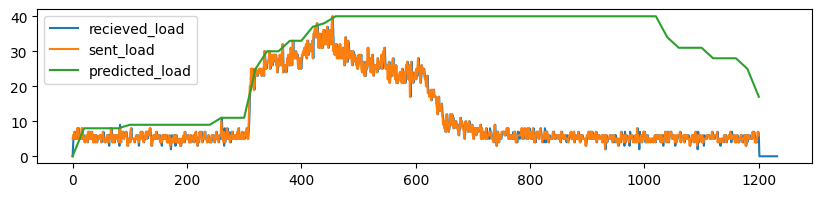

In [405]:
recieved_load = series_changes["recieved_load"]
predicted_load = series_changes["predicted_load"]
# recieved_load = [int(item) for item in recieved_load if item != 0]
recieved_load_x = [x for x in range(0, len(recieved_load))]
sent_load_x = [x for x in range(0, len(sent_load))]
predicted_load_x = series_changes["time_interval"]

print(sent_load)
print(recieved_load)

print(len(sent_load))
print(len(recieved_load))
plt.figure(figsize=(10, 2))
plt.plot(recieved_load_x, recieved_load, label="recieved_load")
plt.plot(sent_load_x, sent_load, label="sent_load")
plt.plot(predicted_load_x, predicted_load, label="predicted_load")
# TODO add predicted reference load here
plt.legend()
plt.show()

## Replica Changes
1. Total
2. Per node

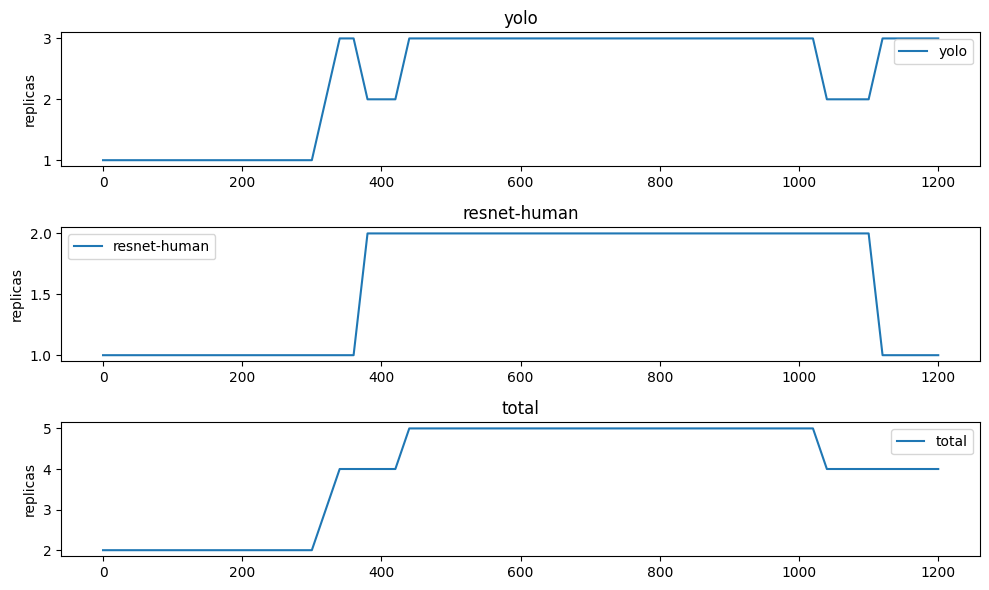

/home/cc/infernece-pipeline-joint-optimization/experiments/utils/drawing.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(x_values)


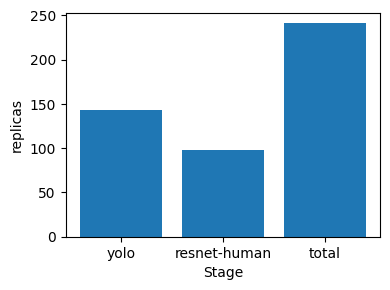

In [406]:
replica_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    replica_changes[node_name] = metrics["replicas"]
    nodes.append(node_name)
replica_changes["total"] = [sum(x) for x in zip(*replica_changes.values())]
ylabel="replicas"
draw_temporal(replica_changes, adaptation_interval, ylabel=ylabel)
draw_cumulative(replica_changes, ylabel=ylabel)

## Per Container Core changes
1. Total
2. Per Node

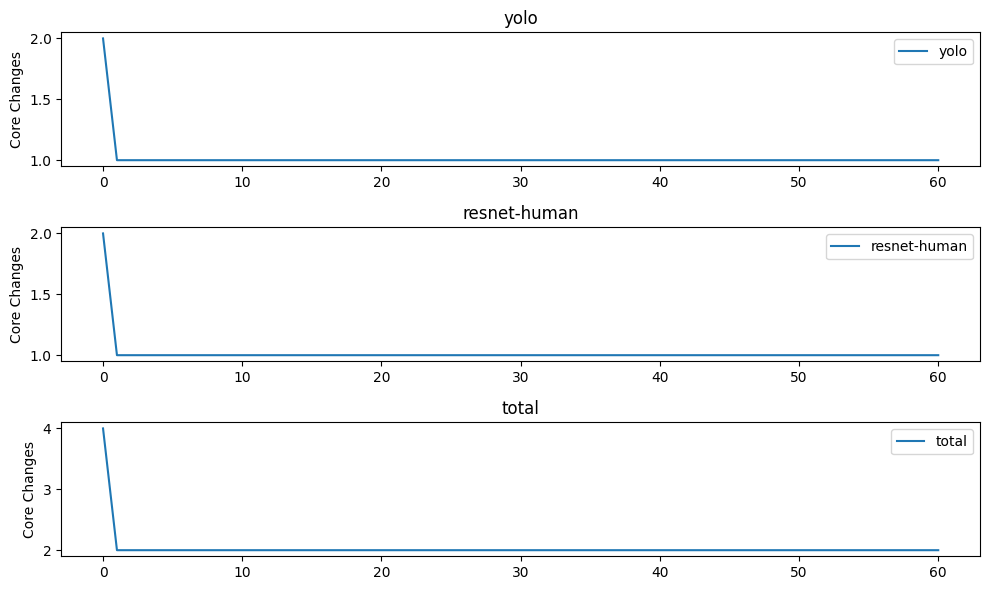

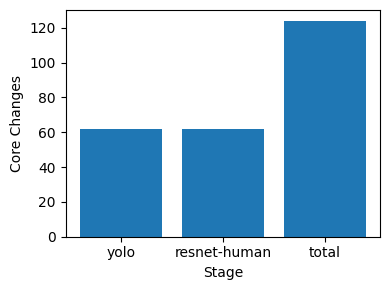

In [407]:
core_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    core_changes[node_name] = metrics["cpu"]
    nodes.append(node_name)
core_changes["total"] = [sum(x) for x in zip(*core_changes.values())]
ylabel="Core Changes"
draw_temporal(core_changes, ylabel=ylabel)
draw_cumulative(core_changes, ylabel=ylabel)

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

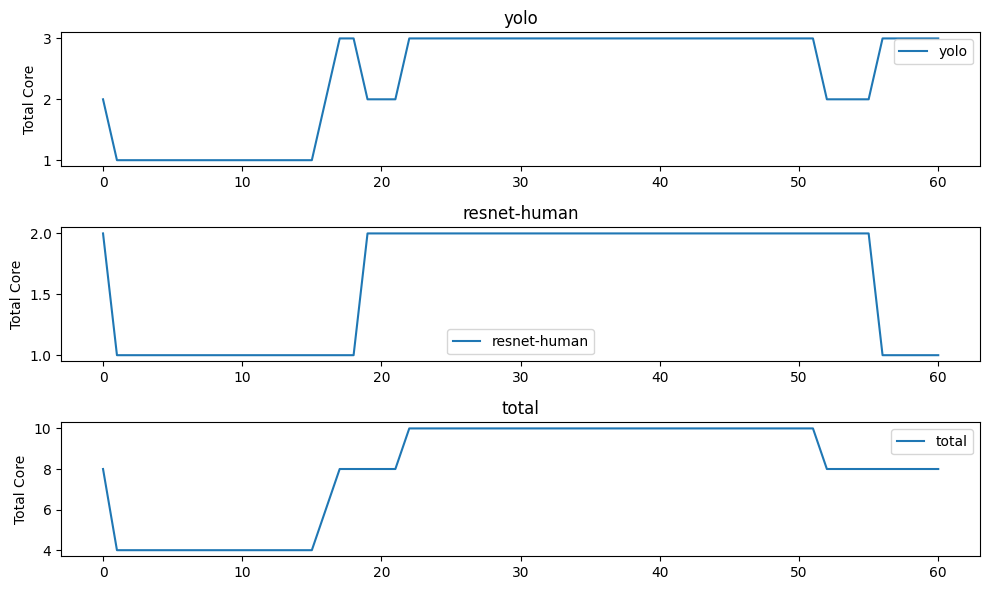

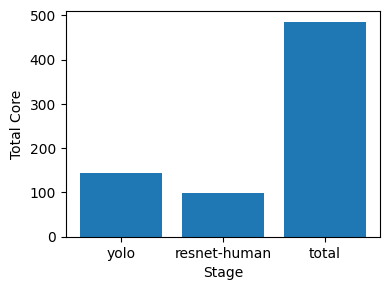

In [408]:
total_core_changes = {}
for key in replica_changes.keys():
    total_core_changes[key] = [
        x * y for x, y in zip(replica_changes[key], core_changes[key])
    ]
ylabel = "Total Core"
draw_temporal(total_core_changes, ylabel=ylabel)
draw_cumulative(total_core_changes, ylabel=ylabel)

## Accuracy Changes

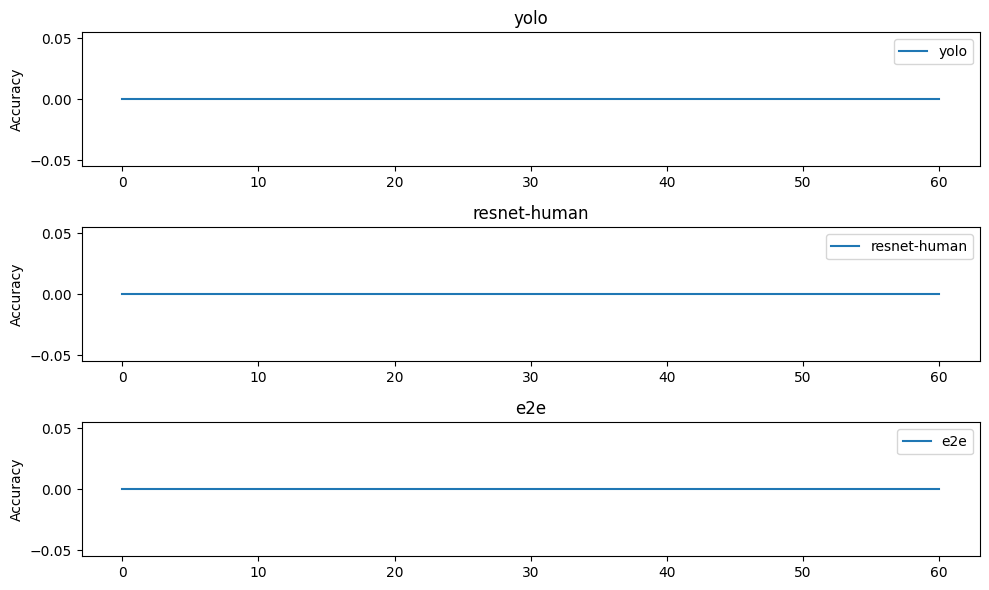

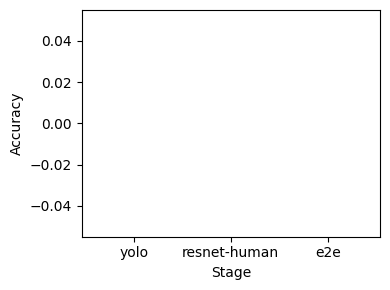

In [409]:
accuracy_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    accuracy_changes[node_name] = metrics["accuracy"]
    nodes.append(node_name)
# replica_changes['total'] = []
if accuracy_method == "sum":
    accuracy_changes["e2e"] = [sum(x) for x in zip(*accuracy_changes.values())]
ylabel = "Accuracy"
draw_temporal(accuracy_changes, ylabel=ylabel)
draw_cumulative(accuracy_changes, ylabel=ylabel)

## Batching Changes

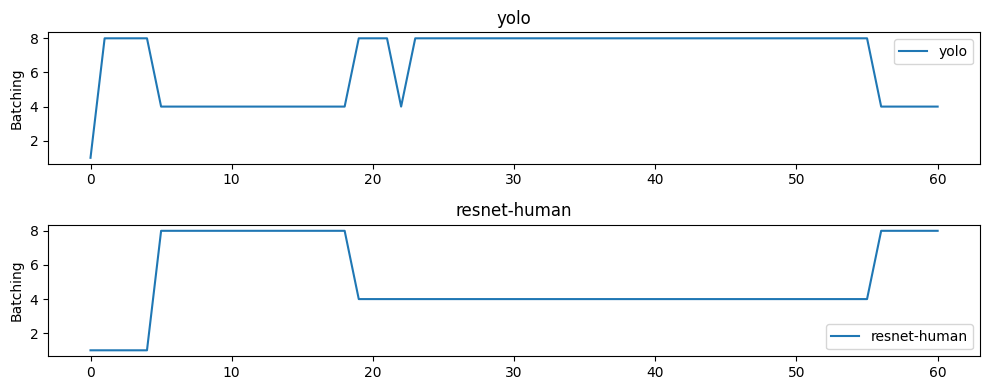

In [410]:
batching_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    batching_changes[node_name] = metrics["batch"]
    nodes.append(node_name)
ylabel = "Batching"
draw_temporal(batching_changes, ylabel=ylabel)
# draw_cumulative(batching_changes)

# Expected Throughput

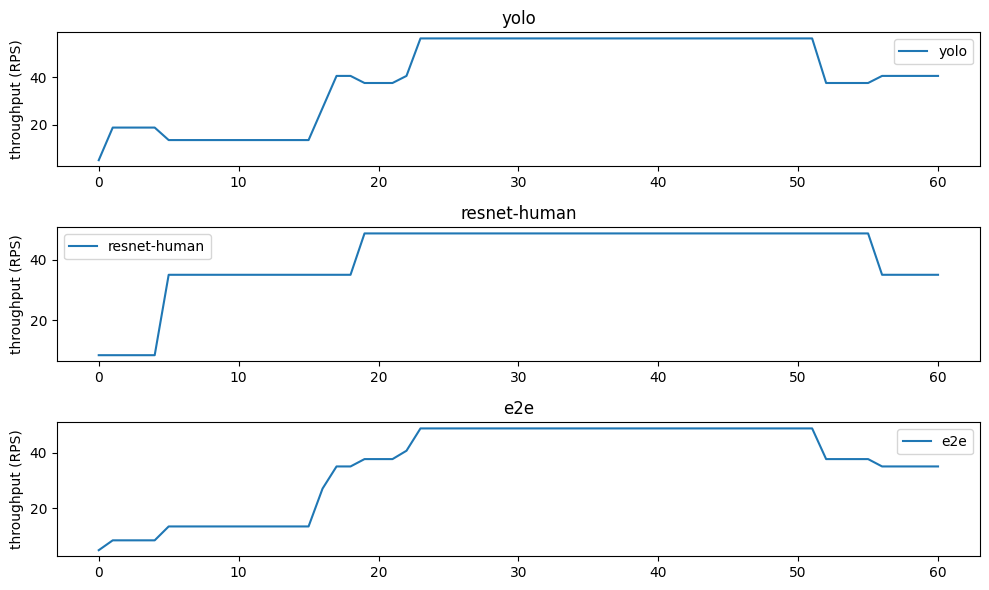

In [411]:
throughput_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    throughput_changes[node_name] = metrics["throughput"]
    nodes.append(node_name)
# replica_changes['total'] = []
ylabel = "throughput (RPS)"
throughput_changes["e2e"] = [min(x) for x in zip(*throughput_changes.values())]
draw_temporal(throughput_changes, ylabel=ylabel)
# draw_cumulative(throughput_changes)

## Expected Latency

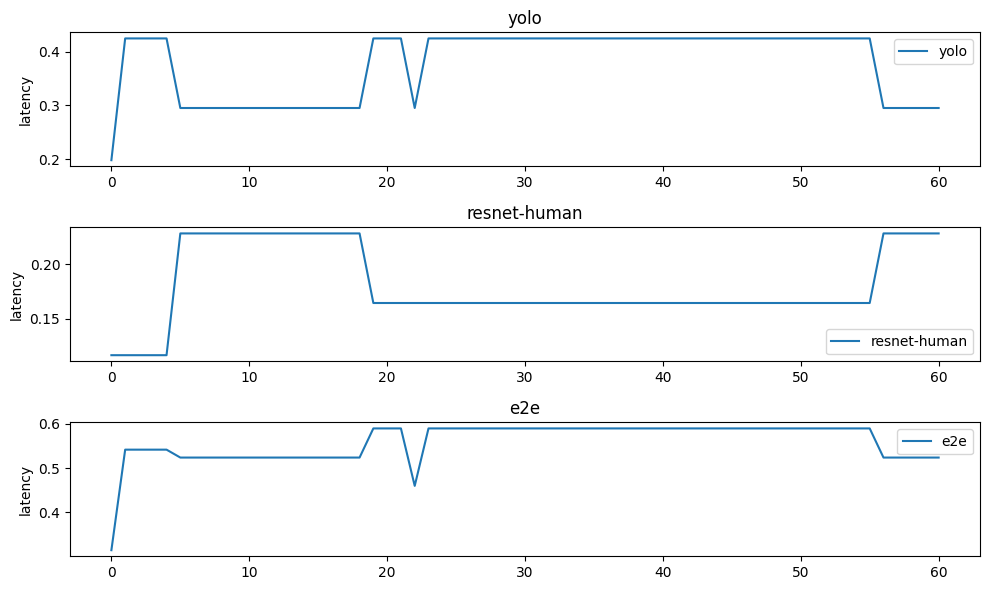

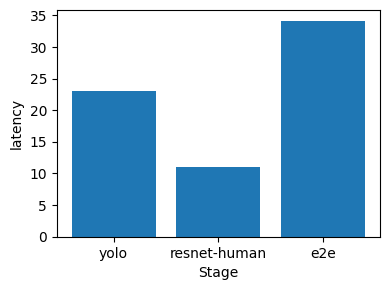

In [412]:
latency_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    latency_changes[node_name] = metrics["latency"]
    nodes.append(node_name)
# replica_changes['total'] = []
ylabel = "latency"
latency_changes["e2e"] = [sum(x) for x in zip(*latency_changes.values())]
draw_temporal(latency_changes, ylabel=ylabel)
draw_cumulative(latency_changes, ylabel=ylabel)

# Real Latencies

## Maeseured p99 Latency


In [413]:
if not simulation_mode:
    timeout_per_second, per_second_results = loader.per_second_result_processing()

/tmp/ipykernel_3298001/2900316271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p99_all["p99_e2e"] = p99_all.sum(axis=1).to_list()


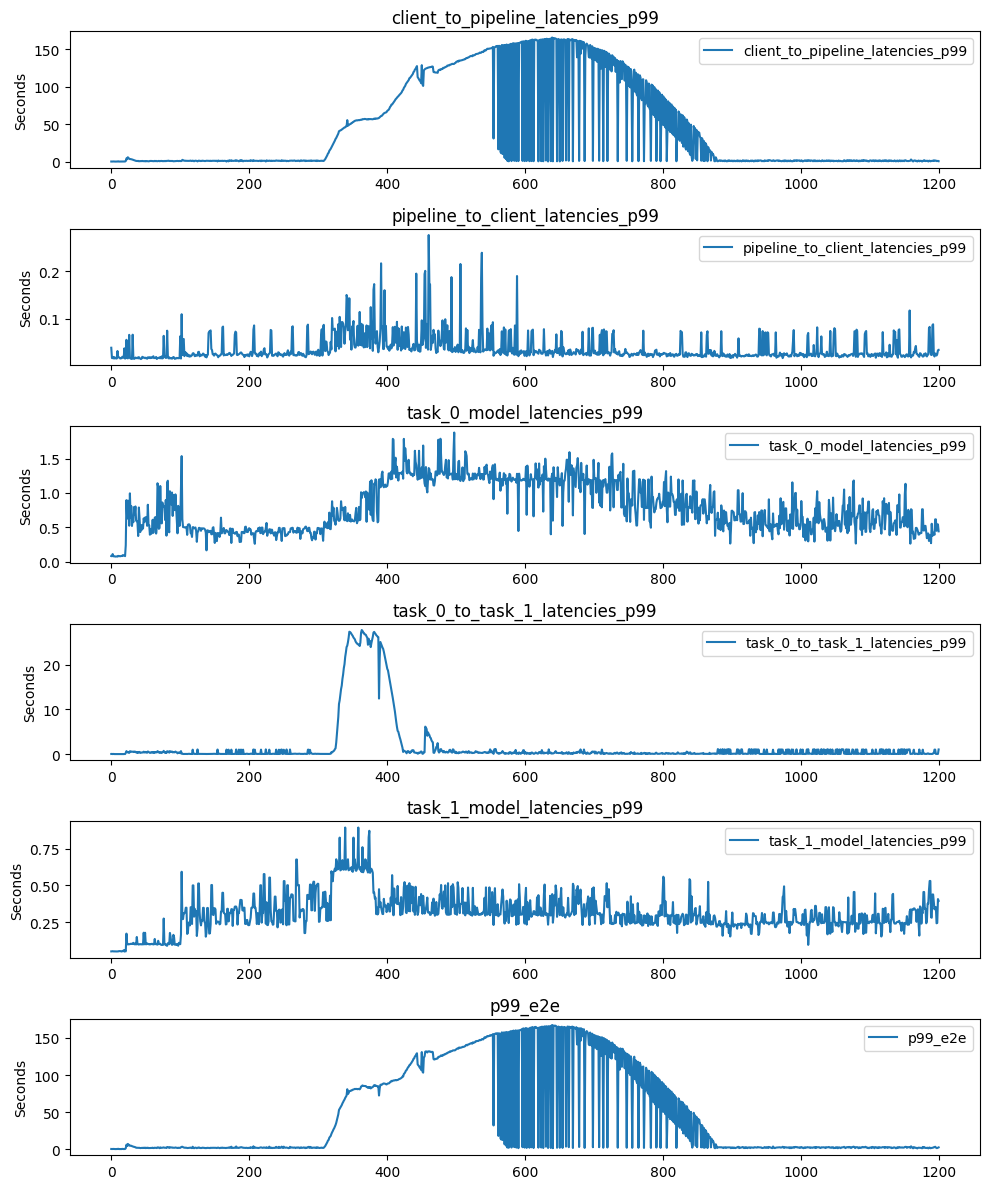

In [414]:
if not simulation_mode:
    p99_cols = list(filter(lambda col: "p99" in col, per_second_results.columns))
    p99_all = per_second_results[p99_cols]  # [1400:]
    p99_all["p99_e2e"] = p99_all.sum(axis=1).to_list()
    ylabel = "Seconds"
    draw_temporal(p99_all.to_dict(orient="list"), ylabel=ylabel)
    # draw_cumulative()

# Every point a change was triggered

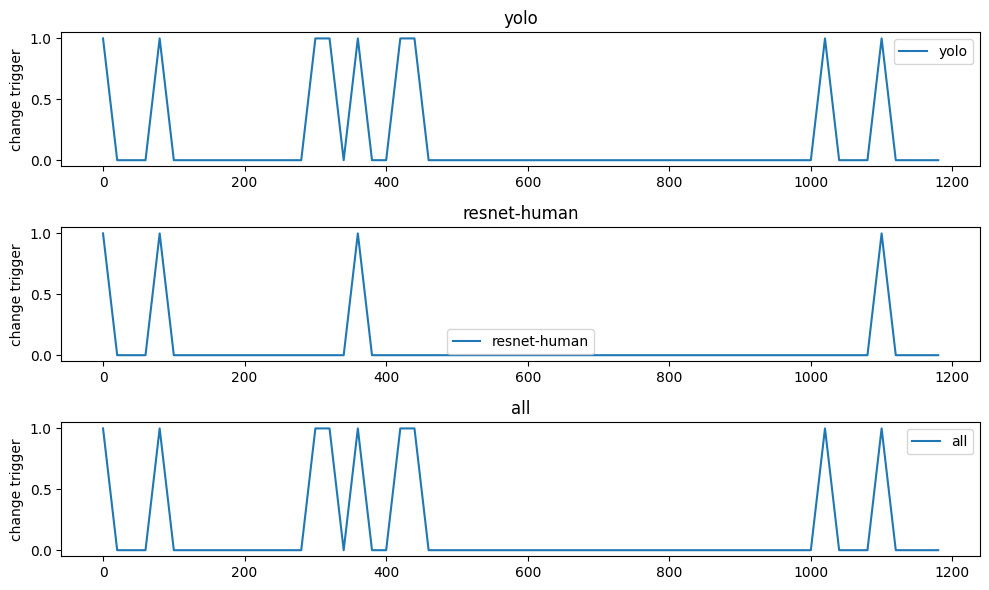

In [415]:
series_changes.keys()
change_trigger = loader.points_with_change(adaptation_log=adaptation_log)
change_trigger["all"] = [any(x) for x in zip(*change_trigger.values())]
ylabel = "change trigger"
draw_temporal(change_trigger, adaptation_interval=adaptation_interval, ylabel=ylabel)

# Changes in the objective

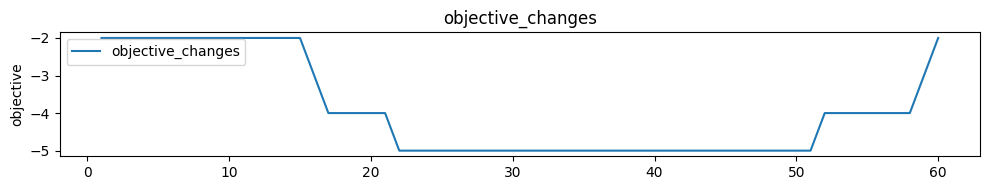

In [416]:
objective_changes = series_changes["objective"]
objective_changes = {"objective_changes": objective_changes}
ylabel = "objective"
draw_temporal(objective_changes, ylabel=ylabel)

## Config Change

In [417]:
# TODO sent load -> extract the sent date from twitter trace and also from the recived load on the server
# TODO model ranks/accuracies -> 1. load accuracy scores 2. start with Mehran but go rank based
# TODO model CPU usgages
# TODO SLA violations
# TODO

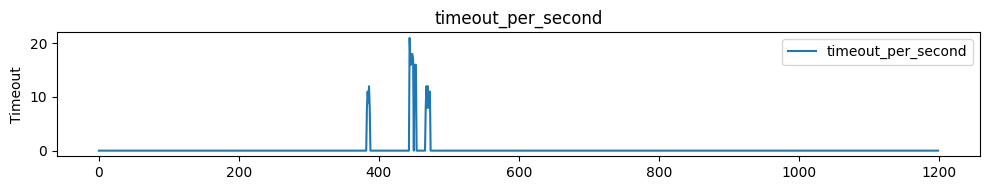

271 out of 13814


In [418]:
ylabel = "Timeout"
if not simulation_mode:
    timeout_dics = {"timeout_per_second": timeout_per_second}
    draw_temporal(timeout_dics, ylabel=ylabel)
    print(f"{sum(timeout_per_second)} out of {sum(sent_load)}")

In [419]:
for key, value in series_changes.items():
    if key == "nodes":
        for node_name, all_configs in value.items():
            print(f"node: {node_name}\n")
            for config_name, config_values in all_configs.items():
                print(f"{config_name}: {config_values}")

node: yolo

cpu: [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
replicas: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3]
batch: [1, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4]
variant: ['yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n

In [420]:
yolo = pd.DataFrame(series_changes["nodes"]["yolo"])
resnet_human = pd.DataFrame(series_changes["nodes"]["resnet-human"])

In [425]:
yolo[yolo["throughput"]>56]

,cpu,replicas,batch,variant,latency,accuracy,throughput
23,1,3,8,yolov5n,0.424993,0.0,56.47148
24,1,3,8,yolov5n,0.424993,0.0,56.47148
25,1,3,8,yolov5n,0.424993,0.0,56.47148
26,1,3,8,yolov5n,0.424993,0.0,56.47148
27,1,3,8,yolov5n,0.424993,0.0,56.47148
28,1,3,8,yolov5n,0.424993,0.0,56.47148
29,1,3,8,yolov5n,0.424993,0.0,56.47148
30,1,3,8,yolov5n,0.424993,0.0,56.47148
31,1,3,8,yolov5n,0.424993,0.0,56.47148
32,1,3,8,yolov5n,0.424993,0.0,56.47148


In [426]:
resnet_human[resnet_human["throughput"]>48]

,cpu,replicas,batch,variant,latency,accuracy,throughput
19,1,2,4,resnet18,0.164529,0.0,48.623777
20,1,2,4,resnet18,0.164529,0.0,48.623777
21,1,2,4,resnet18,0.164529,0.0,48.623777
22,1,2,4,resnet18,0.164529,0.0,48.623777
23,1,2,4,resnet18,0.164529,0.0,48.623777
24,1,2,4,resnet18,0.164529,0.0,48.623777
25,1,2,4,resnet18,0.164529,0.0,48.623777
26,1,2,4,resnet18,0.164529,0.0,48.623777
27,1,2,4,resnet18,0.164529,0.0,48.623777
28,1,2,4,resnet18,0.164529,0.0,48.623777
